In [1]:
import pandas as pd
import yfinance as yf
import os
from dotenv import load_dotenv
import fredapi
from fredapi import Fred
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key=api_key)

In [30]:
housing_index = fred.get_series('CSUSHPISA', observation_start='1990-01-01', observation_end='2022-03-01')
housing_index = housing_index.dropna()
housing_index.tail()

2021-10-01    273.136
2021-11-01    276.417
2021-12-01    279.889
2022-01-01    284.341
2022-02-01    289.744
dtype: float64

<AxesSubplot:title={'center':'Case-Shiller National Home Price Index Historical'}, xlabel='Date', ylabel='Index'>

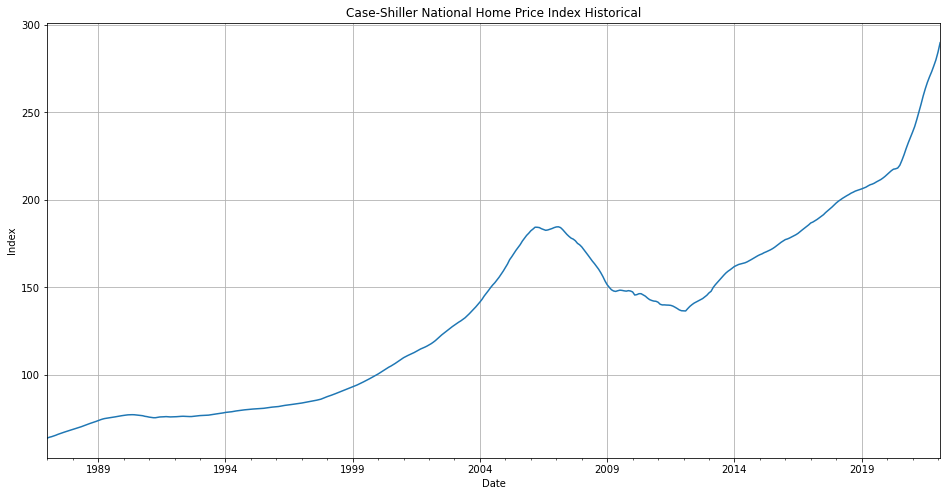

In [6]:
housing_index.plot(figsize=(16,8), title='Case-Shiller National Home Price Index Historical', grid=True, xlabel='Date', ylabel='Index')

In [33]:
# Pull S&P 500 historical data
ticker = "^GSPC" 
start= "1990-01-01" 
end= "2022-02-02"

sp_history = yf.download(ticker, start=start, end=end, progress=False)
sp_history = sp_history.asfreq(freq='D').ffill().dropna()
sp_history.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-28,4336.189941,4432.720215,4292.459961,4431.850098,4431.850098,3.936030e+09
2022-01-29,4336.189941,4432.720215,4292.459961,4431.850098,4431.850098,3.936030e+09
2022-01-30,4336.189941,4432.720215,4292.459961,4431.850098,4431.850098,3.936030e+09
2022-01-31,4431.790039,4516.890137,4414.020020,4515.549805,4515.549805,4.001950e+09
2022-02-01,4519.569824,4550.490234,4483.529785,4546.540039,4546.540039,3.796450e+09


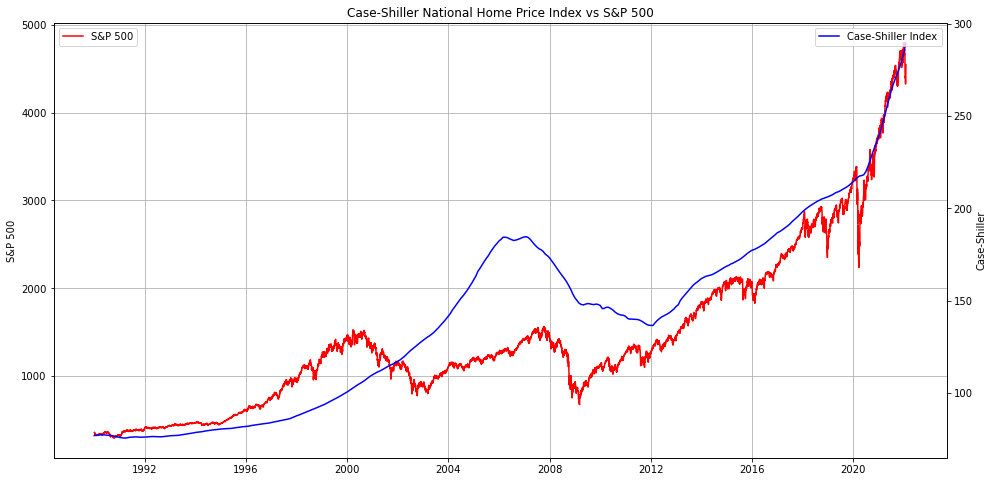

In [34]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(sp_history['Adj Close'], label ='S&P 500', color='r')
ax.set_ylabel('S&P 500')
plt.grid()
ax.legend(loc='upper left')

ax2 = ax.twinx()
plt.plot(housing_index, label='Case-Shiller Index', color='b')
ax.set_title('Case-Shiller National Home Price Index vs S&P 500')
ax2.set_ylabel('Case-Shiller')
ax2.legend(loc='upper right')

In [35]:
# Pull Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
cpi = fred.get_series('CPIAUCSL', observation_start='2018-01-01')
cpi.tail()

2021-11-01    278.524
2021-12-01    280.126
2022-01-01    281.933
2022-02-01    284.182
2022-03-01    287.708
dtype: float64

In [36]:
cpi_percent_change = cpi.pct_change().dropna()
cpi_percent_change.tail()

2021-11-01    0.006992
2021-12-01    0.005752
2022-01-01    0.006451
2022-02-01    0.007977
2022-03-01    0.012408
dtype: float64

In [37]:
# Concat Housing Index and CPI data, monthly freq
combined = pd.concat([housing_index, cpi, cpi_percent_change], axis=1).dropna()
combined['house_index'] = combined[0] * 1000 # convert to dollar value 
combined['cpi'] = combined[1]
combined['cpi_pct_chg'] = combined[2]
combined = combined.drop([combined.columns[0], combined.columns[1], combined.columns[2]], axis=1)
combined = combined['2018-01-01':].round(3)
combined.tail()

,house_index,cpi,cpi_pct_chg
2021-10-01,273136.0,276.590,0.009
2021-11-01,276417.0,278.524,0.007
2021-12-01,279889.0,280.126,0.006
2022-01-01,284341.0,281.933,0.006
2022-02-01,289744.0,284.182,0.008


In [38]:
# Set reference CPI cost for comparison
ref_cpi_cost = cpi['2018-01-01'] 
ref_cpi_cost

248.743

In [39]:
# Adjust Case-Schiller Index for inflation
combined['house_index_inf_adj'] = (combined['house_index'] / combined['cpi']) * ref_cpi_cost
combined.tail()

,house_index,cpi,cpi_pct_chg,house_index_inf_adj
2021-10-01,273136.0,276.590,0.009,245636.747706
2021-11-01,276417.0,278.524,0.007,246861.289623
2021-12-01,279889.0,280.126,0.006,248532.551520
2022-01-01,284341.0,281.933,0.006,250867.523004
2022-02-01,289744.0,284.182,0.008,253611.389152


<AxesSubplot:title={'center':'Case-Schiller Index Inflation Adjusted - period 01-01-2018 - 12-01-2021 (reference CPI 01-01-2018)'}, xlabel='Date', ylabel='Case-Schiller'>

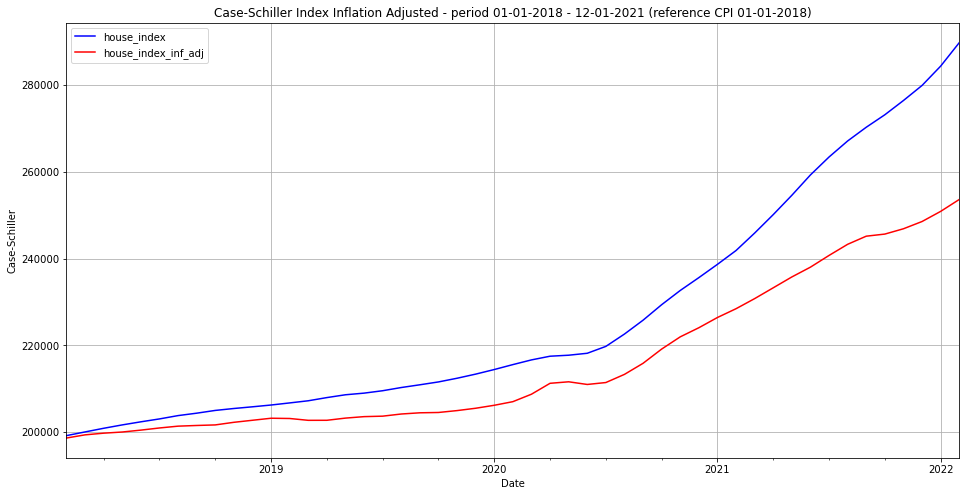

In [40]:
# Plot increase in housing prices for the specified time period
combined[['house_index', 'house_index_inf_adj']].plot(figsize=(16,8), title='Case-Schiller Index Inflation Adjusted - period 01-01-2018 - 12-01-2021 (reference CPI 01-01-2018)', grid=True, ylabel='Case-Schiller', xlabel='Date',color=('b','r'))